## Betweenness Centrality

In [ ]:
from typing import NamedTuple

class User(NamedTuple):
    id: int
    name: str

users = [User(0, "Hero"), User(1, "Dunn"), User(2, "Sue"), User(3, "Chi"),
         User(4, "Thor"), User(5, "Clive"), User(6, "Hicks"),
         User(7, "Devin"), User(8, "Kate"), User(9, "Klein")]

In [ ]:
friend_pairs = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 4),
                (4, 5), (5, 6), (5, 7), (6, 8), (7, 8), (8, 9)]

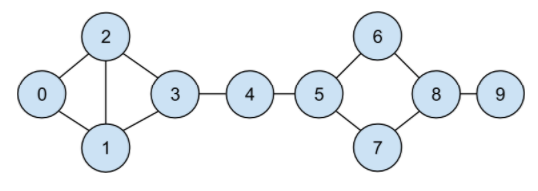

In [ ]:
from typing import Dict, List

# type alias for keeping track of Friendships
Friendships = Dict[int, List[int]]

friendships: Friendships = {user.id: [] for user in users}

for i, j in friend_pairs:
    friendships[i].append(j)
    friendships[j].append(i)

assert friendships[4] == [3, 5]
assert friendships[8] == [6, 7, 9]

In [ ]:
from collections import deque

Path = List[int]

def shortest_paths_from(from_user_id: int,
                        friendships: Friendships) -> Dict[int, List[Path]]:
    # A dictionary from user_id to *all* shortest paths to that user.
    shortest_paths_to: Dict[int, List[Path]] = {from_user_id: [[]]}

    # A queue of (previous user, next user) that we need to check.
    # Starts out with all pairs (from_user, friend_of_from_user).
    frontier = deque((from_user_id, friend_id)
                     for friend_id in friendships[from_user_id])

    # Keep going until we empty the queue.
    while frontier:
        # Remove the pair that's next in the queue.
        prev_user_id, user_id = frontier.popleft()

        # Because of the way we're adding to the queue,
        # necessarily we already know some shortest paths to prev_user.
        paths_to_prev_user = shortest_paths_to[prev_user_id]
        new_paths_to_user = [path + [user_id] for path in paths_to_prev_user]

        # It's possible we already know a shortest path to user_id.
        old_paths_to_user = shortest_paths_to.get(user_id, [])

        # What's the shortest path to here that we've seen so far?
        if old_paths_to_user:
            min_path_length = len(old_paths_to_user[0])
        else:
            min_path_length = float('inf')

        # Only keep paths that aren't too long and are actually new.
        new_paths_to_user = [path
                             for path in new_paths_to_user
                             if len(path) <= min_path_length
                             and path not in old_paths_to_user]

        shortest_paths_to[user_id] = old_paths_to_user + new_paths_to_user

        # Add never-seen neighbors to the frontier.
        frontier.extend((user_id, friend_id)
                        for friend_id in friendships[user_id]
                        if friend_id not in shortest_paths_to)

    return shortest_paths_to

In [ ]:
# For each from_user, for each to_user, a list of shortest paths.
shortest_paths = {user.id: shortest_paths_from(user.id, friendships)
                  for user in users}

In [ ]:
betweenness_centrality = {user.id: 0.0 for user in users}

for source in users:
    for target_id, paths in shortest_paths[source.id].items():
        if source.id < target_id:      # don't double count
            num_paths = len(paths)     # how many shortest paths?
            contrib = 1 / num_paths    # contribution to centrality
            for path in paths:
                for between_id in path:
                    if between_id not in [source.id, target_id]:
                        betweenness_centrality[between_id] += contrib

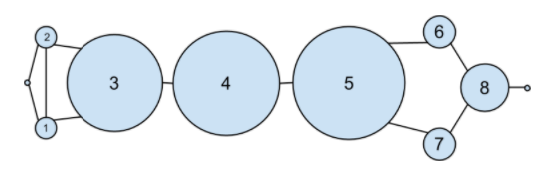

In [ ]:
def farness(user_id: int) -> float:
    """the sum of the lengths of the shortest paths to each other user"""
    return sum(len(paths[0])
               for paths in shortest_paths[user_id].values())

In [ ]:
closeness_centrality = {user.id: 1 / farness(user.id) for user in users}

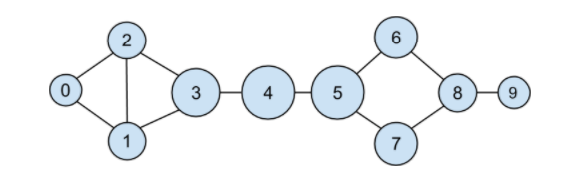

## Eigenvector Centrality

In [ ]:
from scratch.linear_algebra import Matrix, make_matrix, shape

def matrix_times_matrix(m1: Matrix, m2: Matrix) -> Matrix:
    nr1, nc1 = shape(m1)
    nr2, nc2 = shape(m2)
    assert nc1 == nr2, "must have (# of columns in m1) == (# of rows in m2)"

    def entry_fn(i: int, j: int) -> float:
        """dot product of i-th row of m1 with j-th column of m2"""
        return sum(m1[i][k] * m2[k][j] for k in range(nc1))

    return make_matrix(nr1, nc2, entry_fn)

In [ ]:
from scratch.linear_algebra import Vector, dot

def matrix_times_vector(m: Matrix, v: Vector) -> Vector:
    nr, nc = shape(m)
    n = len(v)
    assert nc == n, "must have (# of cols in m) == (# of elements in v)"

    return [dot(row, v) for row in m]  # output has length nr

In [ ]:
from typing import Tuple
import random
from scratch.linear_algebra import magnitude, distance

def find_eigenvector(m: Matrix,
                     tolerance: float = 0.00001) -> Tuple[Vector, float]:
    guess = [random.random() for _ in m]

    while True:
        result = matrix_times_vector(m, guess)    # transform guess
        norm = magnitude(result)                  # compute norm
        next_guess = [x / norm for x in result]   # rescale

        if distance(guess, next_guess) < tolerance:
            # convergence so return (eigenvector, eigenvalue)
            return next_guess, norm

        guess = next_guess

In [ ]:
rotate = [[ 0, 1],
          [-1, 0]]

In [ ]:
flip = [[0, 1],
        [1, 0]]

In [ ]:
def entry_fn(i: int, j: int):
    return 1 if (i, j) in friend_pairs or (j, i) in friend_pairs else 0

n = len(users)
adjacency_matrix = make_matrix(n, n, entry_fn)

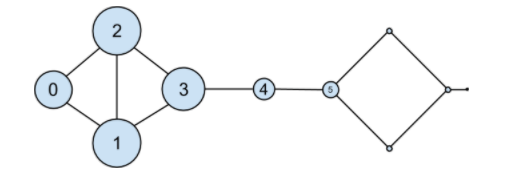

In [ ]:
eigenvector_centralities, _ = find_eigenvector(adjacency_matrix)

In [ ]:
matrix_times_vector(adjacency_matrix, eigenvector_centralities)

In [ ]:
dot(adjacency_matrix[i], eigenvector_centralities)

## Directed Graphs and PageRank

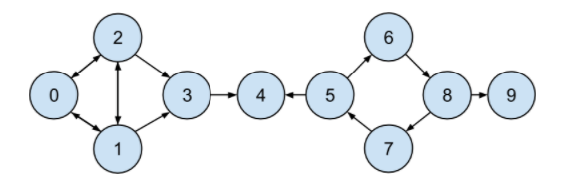

In [ ]:
endorsements = [(0, 1), (1, 0), (0, 2), (2, 0), (1, 2),
                (2, 1), (1, 3), (2, 3), (3, 4), (5, 4),
                (5, 6), (7, 5), (6, 8), (8, 7), (8, 9)]

In [ ]:
from collections import Counter

endorsement_counts = Counter(target for source, target in endorsements)

In [ ]:
import tqdm

def page_rank(users: List[User],
              endorsements: List[Tuple[int, int]],
              damping: float = 0.85,
              num_iters: int = 100) -> Dict[int, float]:
    # Compute how many people each person endorses
    outgoing_counts = Counter(target for source, target in endorsements)

    # Initially distribute PageRank evenly
    num_users = len(users)
    pr = {user.id : 1 / num_users for user in users}

    # Small fraction of PageRank that each node gets each iteration
    base_pr = (1 - damping) / num_users

    for iter in tqdm.trange(num_iters):
        next_pr = {user.id : base_pr for user in users}  # start with base_pr

        for source, target in endorsements:
            # Add damped fraction of source pr to target
            next_pr[target] += damping * pr[source] / outgoing_counts[source]

        pr = next_pr

    return pr

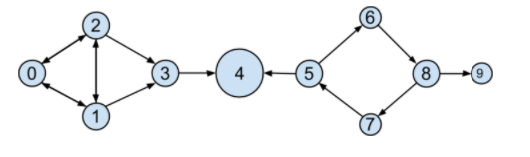